# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 1: Bag-of-Words based Natural Language Inference (30 pts)

In this assignment, you will train a Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.

We have 5 coding questions and 3 written questions. Some coding functions are provided for your reference, but you are welcome to change and write your own functions. You should deliver your training and validation results in written questions.

In [ ]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
from tqdm import notebook
from collections import Counter

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1

In [ ]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/2020.1011/HW/HW2/answer/answer-part1/

/content/drive/.shortcut-targets-by-id/1lw8YIdTE5p10TT6vMJ--f5lc1ycU0hJv/2020.1011/HW/HW2/final/hw2-part1-bow_nli


---
### 1 Dataset (6 pts)
#### Data Processing

In [ ]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/data_after_process/'

hypo_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb"))
prem_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb"))

hypo_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

In [ ]:
# Examples
ind2label = {0: 'neutral', 1:'entailment', 2:'contradiction'}
for idx in [0,1,2]:  
    label = ind2label[idx]
    print('Label: ', label , '\n')
    for idx in np.where(label_index_train == idx)[0][:2]:
        hypo = hypo_data_tokens_train[idx]
        prem = prem_data_tokens_train[idx]
        print(f"Hypothesis: {' '.join(hypo)}")
        print(f"Premise: {' '.join(prem)}")
        print()
    print('-'*100)

Label:  neutral 

Hypothesis: a young girl in a pink shirt sitting on a dock viewing a body of water
Premise: a young girl watching the sunset over the water

Hypothesis: across the river you can see a large building
Premise: the large building is full of apartments and tenants

----------------------------------------------------------------------------------------------------
Label:  entailment 

Hypothesis: a woman is smiling while the man next to her is focused on a blue object with a pattern on it
Premise: two people are next to each other

Hypothesis: a female laying on her stomach in the water outside with umbrellas
Premise: there is a women outdoors

----------------------------------------------------------------------------------------------------
Label:  contradiction 

Hypothesis: a man in white shorts and a black shirt is paragliding on the ocean
Premise: a man is riding a jetski on the ocean

Hypothesis: four black dogs run together on bright green grass
Premise: four dog

**Coding 1: finish `build_vocab` function** (2 pts)


In [ ]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # TODO:
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices
    
    hypo_tokens=[j for i in hypo_tokens for j in i]
    prem_tokens=[j for i in prem_tokens for j in i]
    
    hypo_token_counter = Counter(tuple(hypo_tokens))
    prem_token_counter = Counter(tuple(prem_tokens))

    all_tokens_counter = hypo_token_counter + prem_token_counter

    vocab, count = zip(*all_tokens_counter.most_common(max_vocab_size))

    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab))))
    id2token = ['<unk>', '<pad>'] + id2token
    token2id['<unk>'] = UNK_IDX
    token2id['<pad>'] = PAD_IDX
    return token2id, id2token

**Coding 2: finish `token2index` function** (2 pts)

In [ ]:
def token2index(tokens_data):
    # TODO:
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)
    
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
        
    return indices_data

In [ ]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train)
hypo_data_indices_train = token2index(hypo_data_tokens_train)
prem_data_indices_train = token2index(prem_data_tokens_train)
hypo_data_indices_val = token2index(hypo_data_tokens_val)
prem_data_indices_val= token2index(prem_data_tokens_val)  

#### DataLoader

**Coding 3: finish DataLoader** (2 pts)

In [ ]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=PAD_IDX)
        hypo_list.append(padded_vec)
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=PAD_IDX)
        prem_list.append(padded_vec)
        
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [ ]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
      
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]

        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [ ]:
max_sentence_length = 20
BATCH_SIZE = 1024

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

In [ ]:
# TODO:
# finish DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

---
### 2 Model (8 pts)

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (can use code from [Lab 8 - $\texttt{nnet_models_new.py}$](https://drive.google.com/file/d/1zIEr73vUPKCpl0T6evm2C0XHqinD9XM4/view?usp=sharing) & [Lab 6 - $\texttt{06b-neural_networks.ipynb}$](https://drive.google.com/file/d/1haVHIZ2wWsdVC7hQstuVkmwn_I6giv6p/view?usp=sharing) to complete this class). (8 pts)

In [ ]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type.
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        # TODO: 
        # 1. Embedding
        # 2. Linear Layers
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=1)
        if reduce == 'concat':
            emb_dim *= 2
        self.linear = nn.Linear(emb_dim, n_out)
        

    def forward(self, data_hypo, length_hypo, data_prem, length_prem, reduce):
        """
            @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in the data_prem.
            @param reduce: [sum, concat, element-wise].
            """
        
        # TODO:
        # word embedding
        # combine to sentence
        
        out_hypo = self.embed(data_hypo)
        out_prem = self.embed(data_prem)

        out_hypo = torch.sum(out_hypo, dim=1)
        out_prem = torch.sum(out_prem, dim=1)

        out_hypo /= length_hypo.view(length_hypo.size()[0],1).expand_as(out_hypo).float()
        out_prem /= length_prem.view(length_prem.size()[0],1).expand_as(out_prem).float()
    
        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if reduce == 'concat':
            out = torch.cat((out_hypo,out_prem),1)
        if reduce == 'sum':
            out = torch.add(out_hypo, out_prem)
        if reduce == 'hadamard':
            out = out_hypo * out_prem
            

        # return logits
        out = self.linear(out.float())
        return out

Scratch

In [ ]:
emb = nn.Embedding(10000, 50, padding_idx=PAD_IDX)
data_hypo, lengths_hypo, data_prem, lengths_prem, labels = iter(train_loader).next()
print(data_hypo.shape)

out_hypo = emb(data_hypo)
print(out_hypo.shape)

out_hypo = torch.sum(out_hypo, dim=1)
print(out_hypo.shape)

print(lengths_hypo.shape)

torch.Size([1024, 20])
torch.Size([1024, 20, 50])
torch.Size([1024, 50])
torch.Size([1024])


In [ ]:
# Several ways to normalize the embedding
print(lengths_hypo.view(lengths_hypo.size()[0],1))
print(lengths_hypo.view(-1,1))
print(lengths_hypo[:,None])

tensor([[ 8],
        [ 9],
        [12],
        ...,
        [ 6],
        [20],
        [15]])
tensor([[ 8],
        [ 9],
        [12],
        ...,
        [ 6],
        [20],
        [15]])
tensor([[ 8],
        [ 9],
        [12],
        ...,
        [ 6],
        [20],
        [15]])


In [ ]:
out_hypo / lengths_hypo.view(lengths_hypo.size()[0],1).expand_as(out_hypo).float()

tensor([[-2.0956e-01,  3.7606e-01,  1.4840e-01,  ...,  1.2335e-01,
         -7.7380e-01, -6.5874e-01],
        [-4.0091e-01,  2.0858e-01,  1.7467e-01,  ..., -3.6479e-01,
         -7.6777e-01, -3.2919e-01],
        [ 4.3959e-01,  3.4063e-01,  1.1450e-01,  ..., -4.3168e-02,
         -3.1203e-01, -1.8678e-01],
        ...,
        [-4.3077e-01,  6.5440e-02,  5.8306e-01,  ..., -9.1264e-01,
         -7.1550e-01, -3.1176e-01],
        [ 7.3829e-01,  5.4313e-01,  7.4510e-04,  ..., -1.3750e-01,
         -1.4668e-01,  3.8328e-02],
        [ 2.2393e-01,  1.9255e-01,  2.8852e-01,  ..., -4.0201e-01,
         -5.9819e-01, -8.8465e-02]], grad_fn=<DivBackward0>)

In [ ]:
out_hypo / lengths_hypo.view(lengths_hypo.size()[0],1)

tensor([[-2.0956e-01,  3.7606e-01,  1.4840e-01,  ...,  1.2335e-01,
         -7.7380e-01, -6.5874e-01],
        [-4.0091e-01,  2.0858e-01,  1.7467e-01,  ..., -3.6479e-01,
         -7.6777e-01, -3.2919e-01],
        [ 4.3959e-01,  3.4063e-01,  1.1450e-01,  ..., -4.3168e-02,
         -3.1203e-01, -1.8678e-01],
        ...,
        [-4.3077e-01,  6.5440e-02,  5.8306e-01,  ..., -9.1264e-01,
         -7.1550e-01, -3.1176e-01],
        [ 7.3829e-01,  5.4313e-01,  7.4510e-04,  ..., -1.3750e-01,
         -1.4668e-01,  3.8328e-02],
        [ 2.2393e-01,  1.9255e-01,  2.8852e-01,  ..., -4.0201e-01,
         -5.9819e-01, -8.8465e-02]], grad_fn=<DivBackward0>)

In [ ]:
out_hypo / lengths_hypo.view(-1,1)

tensor([[-2.0956e-01,  3.7606e-01,  1.4840e-01,  ...,  1.2335e-01,
         -7.7380e-01, -6.5874e-01],
        [-4.0091e-01,  2.0858e-01,  1.7467e-01,  ..., -3.6479e-01,
         -7.6777e-01, -3.2919e-01],
        [ 4.3959e-01,  3.4063e-01,  1.1450e-01,  ..., -4.3168e-02,
         -3.1203e-01, -1.8678e-01],
        ...,
        [-4.3077e-01,  6.5440e-02,  5.8306e-01,  ..., -9.1264e-01,
         -7.1550e-01, -3.1176e-01],
        [ 7.3829e-01,  5.4313e-01,  7.4510e-04,  ..., -1.3750e-01,
         -1.4668e-01,  3.8328e-02],
        [ 2.2393e-01,  1.9255e-01,  2.8852e-01,  ..., -4.0201e-01,
         -5.9819e-01, -8.8465e-02]], grad_fn=<DivBackward0>)

In [ ]:
out_hypo / lengths_hypo[:,None]

tensor([[-2.0956e-01,  3.7606e-01,  1.4840e-01,  ...,  1.2335e-01,
         -7.7380e-01, -6.5874e-01],
        [-4.0091e-01,  2.0858e-01,  1.7467e-01,  ..., -3.6479e-01,
         -7.6777e-01, -3.2919e-01],
        [ 4.3959e-01,  3.4063e-01,  1.1450e-01,  ..., -4.3168e-02,
         -3.1203e-01, -1.8678e-01],
        ...,
        [-4.3077e-01,  6.5440e-02,  5.8306e-01,  ..., -9.1264e-01,
         -7.1550e-01, -3.1176e-01],
        [ 7.3829e-01,  5.4313e-01,  7.4510e-04,  ..., -1.3750e-01,
         -1.4668e-01,  3.8328e-02],
        [ 2.2393e-01,  1.9255e-01,  2.8852e-01,  ..., -4.0201e-01,
         -5.9819e-01, -8.8465e-02]], grad_fn=<DivBackward0>)

---
### 3 Training and Validation (16 pts)

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 


In [ ]:
# Hyper paramters example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 100
# 3. reduce : ["sum", "hadamard", "concat"]
reduce_method = "sum"
# 4. learning_rate
learning_rate =0.05

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 10 
BATCH_SIZE = 1024

param_options = {
    'emb_dim_list': [100, 256, 512],
    'reduce_list' : ["sum", "hadamard", "concat"],
    'lr_list' : [ 0.01, 0.05] }

pre_trained = True


**Coding 5: finish training and validation** (4 pts)

In [ ]:
def train_model(num_epochs, model, interaction_type, criterion, optimizer, train_loader, val_loader):
    best_val_acc = 0.0

    train_losses = [] # record training loss after every epoch
    val_losses = [] # record validation loss after every epoch
    train_accs = [] # record training accuracy after every epoch
    val_accs = [] # record validation accuracy after every epoch

    for epoch in notebook.tqdm(range(num_epochs), desc='Epoch'):
        running_loss_train = 0.0
        running_loss_val = 0.0
        running_acc_train = 0.0
        running_acc_val = 0.0
        correct = 0
        total = 0
        epoch_iterator = notebook.tqdm(train_loader, desc='Iteration')
        for i, (data_hypo, lengths_hypo, data_prem, lengths_prem, labels) in enumerate(epoch_iterator):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_hypo,lengths_hypo,data_prem, lengths_prem, interaction_type)
            # Compute loss
            loss = criterion(outputs,labels)
            # Backward pass
            loss.backward()
            optimizer.step()

            # training loss
            train_loss = loss.item()
            # training acc
            predicted = outputs.max(1, keepdim=True)[1]
            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            train_acc = 100 * correct / total

            running_loss_train += train_loss
            running_acc_train += train_acc
        
        # Evaluation
        model.eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for data_hypo, lengths_hypo, data_prem, lengths_prem, labels in val_loader:
                outputs = model(data_hypo,lengths_hypo,data_prem, lengths_prem, interaction_type)
                
                # Compute loss
                loss = criterion(outputs,labels)
                # val loss
                val_loss = loss.item()
                # val acc
                predicted = outputs.max(1, keepdim=True)[1]
                total += labels.size(0)
                correct += predicted.eq(labels.view_as(predicted)).sum().item()
                val_acc = 100 * correct / total

                running_loss_val += val_loss
                running_acc_val += val_acc

        val_accs.append(running_acc_val/len(val_loader))
        val_losses.append(running_loss_val/len(val_loader))
        train_accs.append(running_acc_train/len(train_loader))
        train_losses.append(running_loss_train/len(train_loader))
            
    result = {'per_epoch': {'train_losses': train_losses,
                            'val_losses': val_losses,
                            'train_accs': train_accs,
                            'val_accs': val_accs}
              }
    return result

In [ ]:
def hyper_param_tuning(options, num_epochs, train_loader, val_loader):
    emb_dim_list = options['emb_dim_list']
    reduce_list = options['reduce_list']

    for emb_dim in emb_dim_list:
        print("emb dim: ", emb_dim)
        for interaction_type in reduce_list:
            print("interaction type: ", interaction_type)
            for learning_rate in learning_rate_list:
                print("learning rate: ", learning_rate)
                filename = "10000_"+str(emb_dim)+"_"+str(interaction_type)+"_"+str(learning_rate)+"_"
                model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), interaction_type)
                # Criterion and Optimizer
                criterion = torch.nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                result =  train_model(num_epochs, model, interaction_type, criterion, optimizer, train_loader, val_loader)

                pkl.dump(result, open("{}.p".format(filename), "wb"))

In [ ]:
if pre_trained == True:
    with open("10000_256_hadamard_0.05_.p", 'rb') as f:
        best_model_losses = pkl.load(f)
else:
    hyper_param_tuning(param_options, num_epochs, train_loader, val_loader)

#### Performance variation based on hyper-parameter values

**Written 1:** (4 pts)
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

In [ ]:
def plot_config(model,filename):

  # Create some mock data
  t = np.arange(0, len(model['per_epoch']['train_accs']))
  train_acc = model['per_epoch']['train_accs']
  val_acc = model['per_epoch']['val_accs']
  train_loss = model['per_epoch']['train_losses']
  val_loss = model['per_epoch']['val_losses']

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('acc', color=color)
  ax1.plot(t, train_acc, color=color, linewidth=1, label = 'train_acc')
  ax1.plot(t, val_acc, color=color, linestyle='dashed', linewidth=1, label = 'val_acc')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.legend(loc='upper left')
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
  ax2.plot(t, train_loss, color=color, linewidth=1, label = 'train_loss')
  ax2.plot(t, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.legend(loc='lower right')
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.title(filename)
  plt.show()

In [ ]:
def compare_hyper_param(options):
    emb_dim_list = options['emb_dim_list']
    reduce_list = options['reduce_list']
    learning_rate_list = options['lr_list']
    best_val = 0.0
    for emb_dim in emb_dim_list:
      for interaction_type in reduce_list:
        for learning_rate in learning_rate_list:
          print("emb dim: ", emb_dim)
          print("interaction type: ", interaction_type)
          print("learning rate: ", learning_rate)
          filename = "10000_"+str(emb_dim)+"_"+str(interaction_type)+"_"+str(learning_rate)+"_"+".p"
          res = pkl.load(open(str(filename), "rb"))
          print(max(res["per_epoch"]["val_accs"]))
          plot_config(res,filename)
          if best_val < max(res["per_epoch"]["val_accs"]):
              best_val = max(res["per_epoch"]["val_accs"])
              best_epoch = np.argmax(res["per_epoch"]["val_accs"]) + 1
              best_emb_dim = emb_dim
              best_inter_type = interaction_type
              best_lr_rate = learning_rate
    print('Best Validation Accuracy: %.2f with vocab_size 10000, emb_dim %d, interaction type %s and learning_rate %.2f after %d epochs' % (best_val, best_emb_dim, best_inter_type, best_lr_rate, best_epoch))

emb dim:  100
interaction type:  sum
learning rate:  0.01
58.3


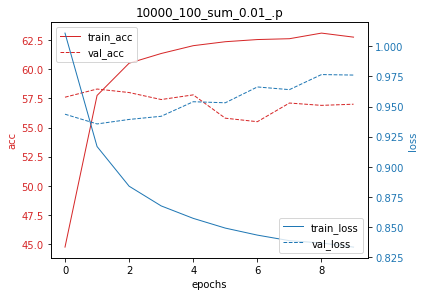

emb dim:  100
interaction type:  sum
learning rate:  0.05
56.2


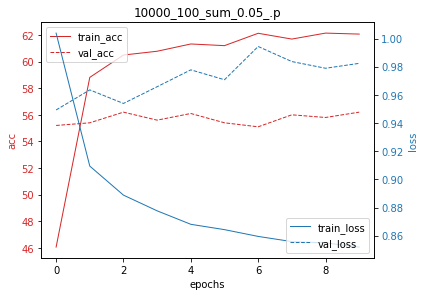

emb dim:  100
interaction type:  hadamard
learning rate:  0.01
64.9


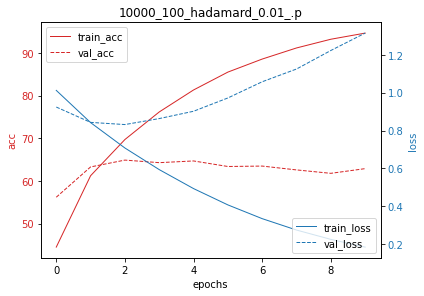

emb dim:  100
interaction type:  hadamard
learning rate:  0.05
64.1


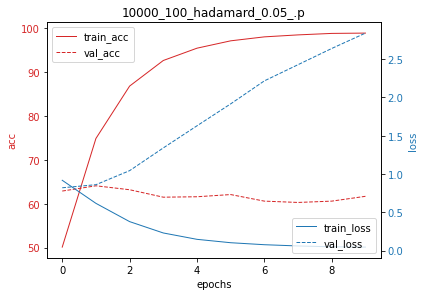

emb dim:  100
interaction type:  concat
learning rate:  0.01
63.3


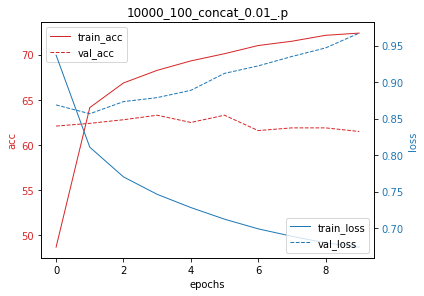

emb dim:  100
interaction type:  concat
learning rate:  0.05
62.6


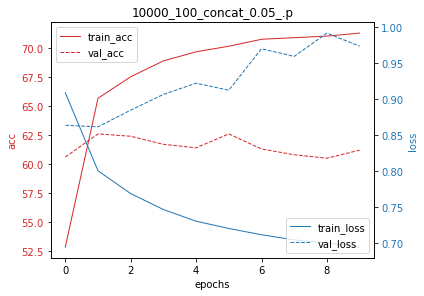

emb dim:  256
interaction type:  sum
learning rate:  0.01
57.6


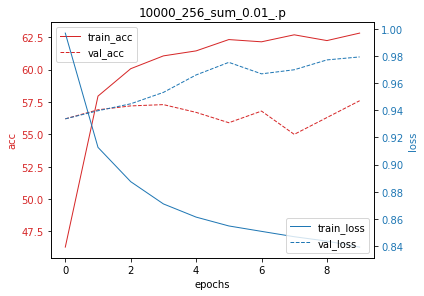

emb dim:  256
interaction type:  sum
learning rate:  0.05
56.5


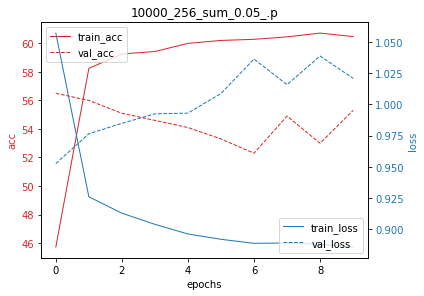

emb dim:  256
interaction type:  hadamard
learning rate:  0.01
65.4


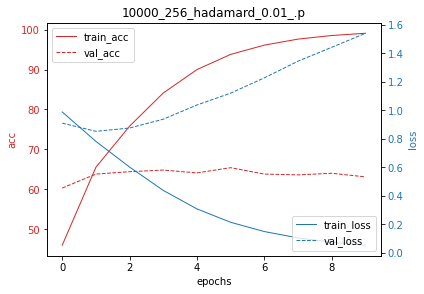

emb dim:  256
interaction type:  hadamard
learning rate:  0.05
66.7


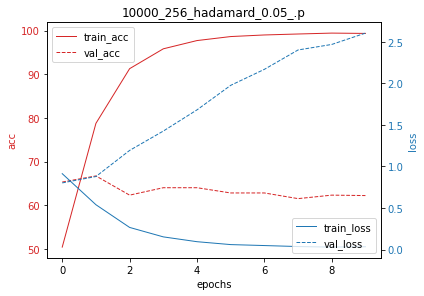

emb dim:  256
interaction type:  concat
learning rate:  0.01
62.0


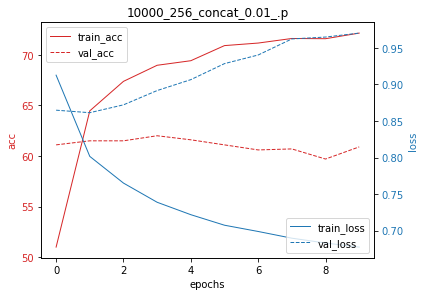

emb dim:  256
interaction type:  concat
learning rate:  0.05
61.7


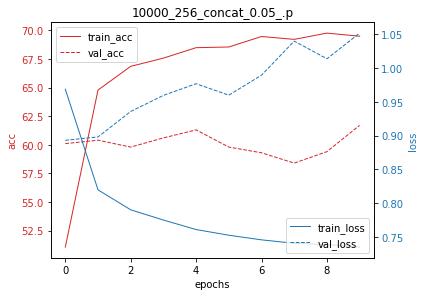

emb dim:  512
interaction type:  sum
learning rate:  0.01
57.5


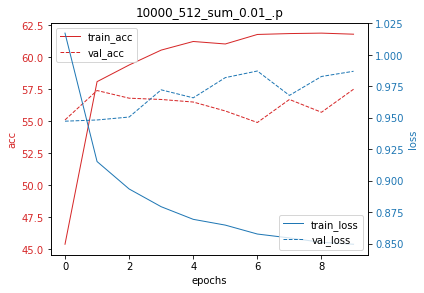

emb dim:  512
interaction type:  sum
learning rate:  0.05
55.0


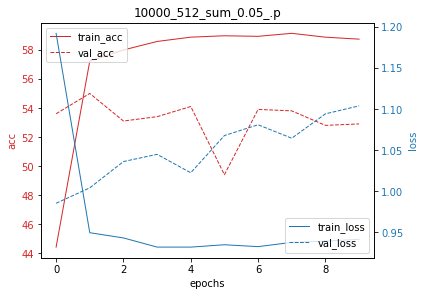

emb dim:  512
interaction type:  hadamard
learning rate:  0.01
62.9


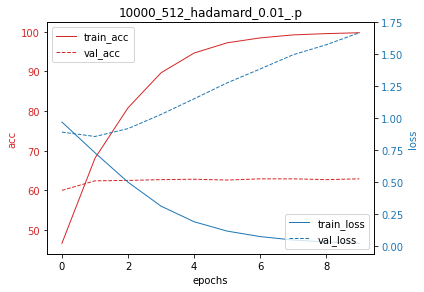

emb dim:  512
interaction type:  hadamard
learning rate:  0.05
66.5


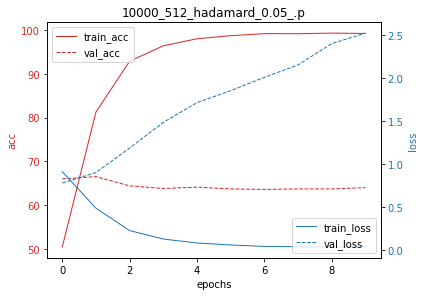

emb dim:  512
interaction type:  concat
learning rate:  0.01
62.6


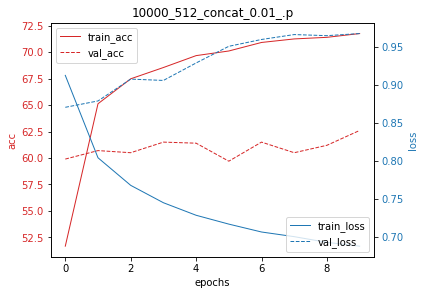

emb dim:  512
interaction type:  concat
learning rate:  0.05
61.6


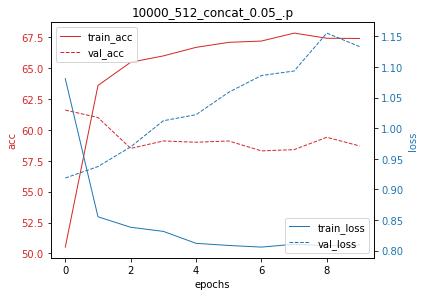

Best Validation Accuracy: 66.70 with vocab_size 10000, emb_dim 256, interaction type hadamard and learning_rate 0.05 after 2 epochs


In [ ]:
# Show plot for each hyper-params combination
compare_hyper_param(param_options)

**Written 2:** (4 pts)   
Take your best model based on validation performace and report its validation accuracy:

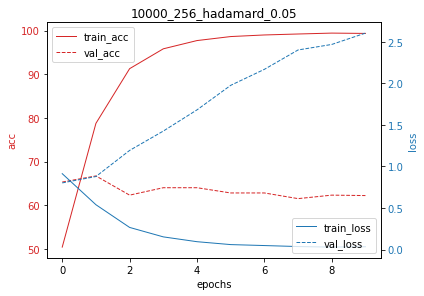

Best Validation Accuracy: 66.7


In [ ]:
# Show best model
plot_config(best_model_losses,"10000_256_hadamard_0.05")
print('Best Validation Accuracy:', max(best_model_losses["per_epoch"]["val_accs"]))

**Written 3:** (4 pts)

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

In [ ]:
best_emb_dim = 256
best_reduce = 'hadamard'
best_lr = 0.05
best_epoch = 2

best_model = LogisticsModelPytorch(len(id2token), best_emb_dim, len(set(label_index_train)), best_reduce)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_lr)
result =  train_model(best_epoch, best_model, best_reduce, criterion, optimizer, train_loader, val_loader)
print('Best Validation Accuracy:', max(result["per_epoch"]["val_accs"]))



Best Validation Accuracy: 66.3


In [ ]:
def analysis(model, ind2label, val_loader):
    best_model.eval()

    with torch.no_grad():
        for data_hypo, lengths_hypo, data_prem, lengths_prem, labels in val_loader:
            outputs = best_model(data_hypo,lengths_hypo,data_prem, lengths_prem, best_reduce)
            
            predicted = outputs.max(1, keepdim=True)[1]

            boolean = predicted.eq(labels.view_as(predicted)).numpy()

            correct_idx = np.where(boolean == True)[0]
            incorrect_idx = np.where(boolean == False)[0]  

    for indicies in [correct_idx, incorrect_idx]:   
        for idx in indicies[:3]:
            hypo = hypo_data_tokens_val[idx]
            prem = prem_data_tokens_val[idx]
            pred = predicted[idx]
            label = labels[idx]

            print(f"Hypothesis: {' '.join(hypo)}")
            print(f"Premise: {' '.join(prem)}")
            print(f"Label: {ind2label[label.item()]}")
            print(f'Prediction: {ind2label[pred.item()]}')
            print()
        print('-'*200)

In [ ]:
analysis(best_model, ind2label, val_loader)

Hypothesis: three women on a stage one wearing red shoes black pants and a gray shirt is sitting on a prop another is sitting on the floor and the third wearing a black shirt and pants is standing as a gentleman in the back tunes an instrument
Premise: there are two women standing on the stage
Label: neutral
Prediction: neutral

Hypothesis: four people sit on a subway two read books one looks at a cellphone and is wearing knee high boots
Premise: multiple people are on a subway together with each of them doing their own thing
Label: entailment
Prediction: entailment

Hypothesis: bicycles stationed while a group of people socialize
Premise: people get together near a stand of bicycles
Label: neutral
Prediction: neutral

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hypothesis: man in overalls with two horses
Premise: a man in overalls